# 환경설정 (버전 충돌 관리)


In [1]:
# # 기존 충돌 라이브러리 제거
# !pip uninstall -y transformers datasets accelerate peft bitsandbytes numpy

# # pip 최신화
# !pip install --upgrade pip

# # 필요한 라이브러리 재설치 (bitsandbytes 제거, 백슬래시 뒤 공백 없음)
# !pip install \
# numpy==1.26.4 \
# transformers==4.39.3 \
# datasets==2.18.0 \
# accelerate==0.29.3 \
# peft==0.10.0

# # 설치 확인
# import numpy as np
# import transformers, datasets, peft

# print("numpy        =", np.__version__)
# print("transformers =", transformers.__version__)
# print("datasets     =", datasets.__version__)
# print("peft         =", peft.__version__)


Found existing installation: transformers 4.39.3
Uninstalling transformers-4.39.3:
  Successfully uninstalled transformers-4.39.3
Found existing installation: datasets 2.18.0
Uninstalling datasets-2.18.0:
  Successfully uninstalled datasets-2.18.0
Found existing installation: accelerate 0.29.3
Uninstalling accelerate-0.29.3:
  Successfully uninstalled accelerate-0.29.3
Found existing installation: peft 0.10.0
Uninstalling peft-0.10.0:
  Successfully uninstalled peft-0.10.0
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached transformers-4.39.3-py3-none-any.whl.metadata (134 kB)
  Using cached datasets-2.18.0-py3-none-any.whl.metadata (20 kB)
  Using cached accelerate-0.29.3-py3-none-any.whl.metadata (18 kB)
  Using cached peft-0.10.0-py3-none-any.whl.metadata (13 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinu

numpy        = 1.26.4
transformers = 4.39.3
datasets     = 2.18.0
peft         = 0.10.0


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# 1. 데이터 로딩

In [2]:
import pandas as pd

# 파일 경로 설정
train_path = "/content/drive/MyDrive/Colab Notebooks/LORA/imdb_train.csv"
test_path = "/content/drive/MyDrive/Colab Notebooks/LORA/imdb_test.csv"
# data_path = "/content/drive/MyDrive/Colab Notebooks/LORA/data.csv"

# 데이터 로딩
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
# data = pd.read_csv(data_path)

# 데이터 크기 출력
print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (40000, 2)
Test shape: (10000, 2)


In [3]:
train.head(10)

,labels,sentences
0,1,For those who think it is strictly potty humor...
1,0,It starts off pretty well with the accident an...
2,0,My best guess is this piece of work will come ...
3,0,FAIL Id love to give this crap a 0 Yes I regis...
4,0,Despite pretty bad reviews I just had to give ...
5,1,Tenshu is imprisoned and sentenced to death Wh...
6,1,Sweeping and still impressive early Talkie Wes...
7,1,This is the only David Zucker movie that does ...
8,1,I think that Key West might do well as a DVD T...
9,1,It is no wonder this movie won 4 prices it is ...


# 2. Tokenizer 적용

In [4]:
from transformers import AutoTokenizer
from sklearn.preprocessing import LabelEncoder
import torch
from datasets import Dataset

# DistilBERT tokenizer 로드
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# ✅ 1. 컬럼명 정리 (CSV 기준: sentences, labels → text, label)
train = train.rename(columns={"sentences": "text", "labels": "label"})
test = test.rename(columns={"sentences": "text", "labels": "label"})

# ✅ 2. 라벨 인코딩 (문자열 라벨 대응)
label_encoder = LabelEncoder()
train['label'] = label_encoder.fit_transform(train['label'])
test['label'] = label_encoder.transform(test['label'])

# ✅ 3. HuggingFace Dataset 변환
train_ds = Dataset.from_pandas(train[['text', 'label']])
test_ds = Dataset.from_pandas(test[['text', 'label']])

# ✅ 4. Tokenizer 적용
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)

train_ds = train_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)

# ✅ 5. 학습용 포맷 지정
train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# ✅ 6. 확인 출력 (NumPy 2.0 호환 방식)
print(train_ds.with_format("python")[0])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

{'text': 'For those who think it is strictly potty humor and immaturity you are in fact the mindless one While the show does contain its share of potty jokes it also contains a lot of satirical material and pokes fun at social problems racial barriers clichésstereotypes etc You just need to read into some of her material a bit more to get it What I also love is that not everything is a punchline For those expecting a formulated joke like Friends I LOVE friends fyi you wont find it here Instead Sarah uses situations and other ways to achieve her humour which is more realistic We dont walk around in this world and have witty punchlines for everything said which is in most comedies Instead the Sarah Silverman Program makes it more realistic in this sense  So dont take it as mindless humor because it is so much more than that', 'label': 1, 'input_ids': [101, 2005, 2216, 2040, 2228, 2009, 2003, 9975, 8962, 3723, 8562, 1998, 10047, 18900, 25137, 2017, 2024, 1999, 2755, 1996, 2568, 3238, 2028

# 3. FULL - FineTuning

In [5]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score
from datetime import datetime
import pandas as pd

# 1. 평가 지표 함수 정의 (정확도)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

# 2. 사전학습 모델 로드
model_ft = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# 3. 학습 설정
training_args_ft = TrainingArguments(
    output_dir="./bert_ft_output",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=5e-5,
    logging_dir="./bert_ft_logs",
    logging_steps=100,
    report_to="none"
)

# 4. Trainer 구성 (정확도 포함)
trainer_ft = Trainer(
    model=model_ft,
    args=training_args_ft,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics  # 정확도 계산 활성화
)

# 5. 학습 수행
trainer_ft.train()

# 6. 평가 수행 및 결과 저장
eval_result_ft = trainer_ft.evaluate()
model_ft.save_pretrained("./bert_ft_model")

# 7. 결과 확인
print(f"Fine-Tuning 결과: 정확도 = {eval_result_ft['eval_accuracy']*100:.2f}%, 손실 = {eval_result_ft['eval_loss']:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.247800,0.198533,0.924600
2,0.146900,0.239353,0.926500
3,0.064100,0.322670,0.930900


Fine-Tuning 결과: 정확도 = 93.09%, 손실 = 0.3227


# 4. Prefix Tuning 적용(PEFT)

In [6]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import get_peft_model, PrefixTuningConfig, TaskType
from sklearn.metrics import accuracy_score
from datetime import datetime
import pandas as pd

# 1. 평가 지표 함수 정의
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

# 2. 사전학습 모델 로드
base_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# 3. Prefix Tuning 설정
peft_config = PrefixTuningConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    num_virtual_tokens=20,
    encoder_hidden_size=512,
    prefix_projection=True,
    num_layers=12,
    token_dim=768,
    num_attention_heads=12
)

# 4. Prefix 모델 적용
model_prefix = get_peft_model(base_model, peft_config)
model_prefix.print_trainable_parameters()

# 5. 학습 설정
training_args_prefix = TrainingArguments(
    output_dir="./bert_prefix_output",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=5e-5,
    logging_dir="./bert_prefix_logs",
    logging_steps=100,
    report_to="none"
)

# 6. Trainer 구성
trainer_prefix = Trainer(
    model=model_prefix,
    args=training_args_prefix,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics  # 정확도 포함
)

# 7. 학습 수행
trainer_prefix.train()

# 8. 평가 및 결과 저장
eval_result_prefix = trainer_prefix.evaluate()
model_prefix.save_pretrained("./bert_prefix_model")

# 9. 결과 출력
print(f"Prefix Tuning 결과: 정확도 = {eval_result_prefix['eval_accuracy']*100:.2f}%, 손실 = {eval_result_prefix['eval_loss']:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_

trainable params: 9,866,242 || all params: 119,350,020 || trainable%: 8.266644613884438


Epoch,Training Loss,Validation Loss,Accuracy
1,0.273000,0.249222,0.898300
2,0.241600,0.233051,0.906400
3,0.225600,0.237413,0.907900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Prefix Tuning 결과: 정확도 = 90.79%, 손실 = 0.2374


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# 5.성능비교

In [14]:
from tabulate import tabulate  # 없으면 pip install tabulate
import pandas as pd

# 결과 수집
results_ft = {
    "Method": "Fine-Tuning",
    "Eval Loss": round(eval_result_ft["eval_loss"], 4),
    "Eval Accuracy (%)": round(eval_result_ft["eval_accuracy"] * 100, 2),
    "Trainable Params": f"{model_ft.num_parameters():,}"
}

results_prefix = {
    "Method": "Prefix Tuning",
    "Eval Loss": round(eval_result_prefix["eval_loss"], 4),
    "Eval Accuracy (%)": round(eval_result_prefix["eval_accuracy"] * 100, 2),
    "Trainable Params": f"{sum(p.numel() for p in model_prefix.parameters() if p.requires_grad):,}"
}

# DataFrame으로 구성
df_results = pd.DataFrame([results_ft, results_prefix])

# 보기 좋게 출력
print(tabulate(df_results, headers="keys", tablefmt="grid", showindex=False))


+---------------+-------------+---------------------+--------------------+
| Method        |   Eval Loss |   Eval Accuracy (%) | Trainable Params   |
+===============+=============+=====================+====================+
| Fine-Tuning   |      0.3227 |               93.09 | 109,483,778        |
+---------------+-------------+---------------------+--------------------+
| Prefix Tuning |      0.2374 |               90.79 | 9,866,242          |
+---------------+-------------+---------------------+--------------------+


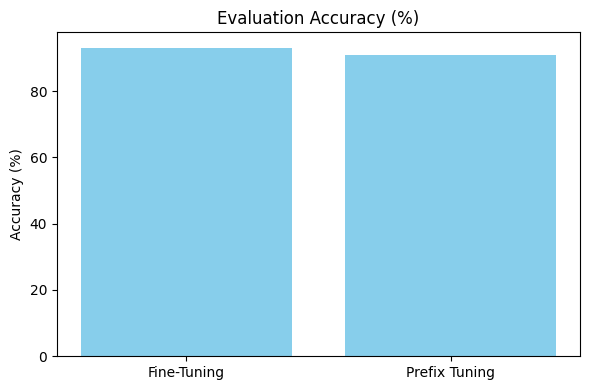

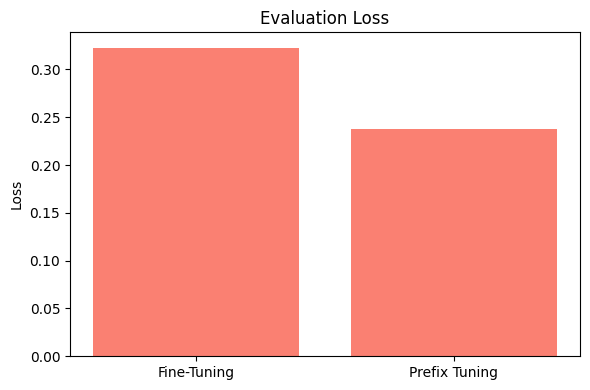

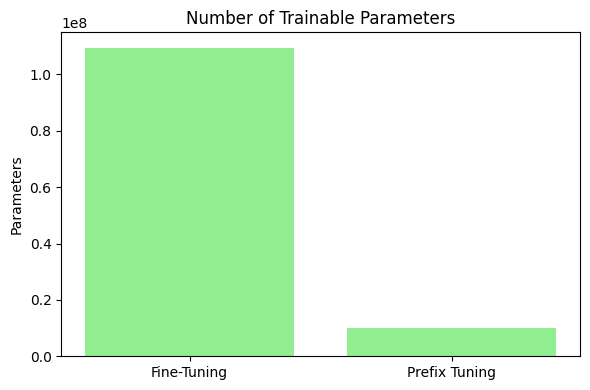

[Fine-Tuning] Accuracy: 93.09%, Loss: 0.3227, Trainable Params: 109,483,778
[Prefix Tuning] Accuracy: 90.79%, Loss: 0.2374, Trainable Params: 9,866,242


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

# 경고 메시지 무시
warnings.filterwarnings("ignore")

# 1. 평가 결과 정리
results_ft = {
    "method": "Fine-Tuning",
    "eval_loss": round(eval_result_ft["eval_loss"], 4),
    "eval_accuracy": round(eval_result_ft["eval_accuracy"] * 100, 2),
    "trainable_params": model_ft.num_parameters(),
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

results_prefix = {
    "method": "Prefix Tuning",
    "eval_loss": round(eval_result_prefix["eval_loss"], 4),
    "eval_accuracy": round(eval_result_prefix["eval_accuracy"] * 100, 2),
    "trainable_params": sum(p.numel() for p in model_prefix.parameters() if p.requires_grad),
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

# 2. 비교표 생성 및 저장
df_results = pd.DataFrame([results_ft, results_prefix])
df_results.to_csv("tuning_comparison_results.csv", index=False)

# 3-1. Accuracy 시각화
plt.figure(figsize=(6, 4))
plt.bar(df_results["method"], df_results["eval_accuracy"], color="skyblue")
plt.title("Evaluation Accuracy (%)")
plt.ylabel("Accuracy (%)")
plt.tight_layout()
plt.savefig("plot_accuracy.png")
plt.show()

# 3-2. Loss 시각화
plt.figure(figsize=(6, 4))
plt.bar(df_results["method"], df_results["eval_loss"], color="salmon")
plt.title("Evaluation Loss")
plt.ylabel("Loss")
plt.tight_layout()
plt.savefig("plot_loss.png")
plt.show()

# 3-3. Trainable Parameters 시각화
plt.figure(figsize=(6, 4))
plt.bar(df_results["method"], df_results["trainable_params"], color="lightgreen")
plt.title("Number of Trainable Parameters")
plt.ylabel("Parameters")
plt.tight_layout()
plt.savefig("plot_params.png")
plt.show()

# 4. 텍스트 출력
for _, row in df_results.iterrows():
    print(f"[{row['method']}] Accuracy: {row['eval_accuracy']}%, Loss: {row['eval_loss']}, Trainable Params: {row['trainable_params']:,}")
